# Quantum Process Tomography using the KLM CNOT Gate in Perceval

This notebook is directed to explain how a Quantum Process Tomography experiment can be performed in Perceval. 2 qubit Heralded CNOT gate (created using the KLM protocol) is used as the *target* gate operation under study to demonstrate the experiment and the results.

## Quantum Process Tomography
Quantum Process Tomography (QPT) is a tool to reconstruct the mathematical operation associated to a physical gate by a series of different measurements on different inputs. QPT scales exponentially with the number of qubits. Any quantum channel (completely positive quantum operation) has a $\chi$ matrix representation : $$\varepsilon(\rho)=\sum_{m,n}\chi_{mn}E_m\rho E_n^{\dag}$$QPT reconstructs the $\chi$ matrix.


In [1]:
import perceval as pcvl
import numpy as np
from perceval.components import catalog
from perceval.components.source import Source
from perceval.algorithm import ProcessTomography
from perceval.algorithm.tomography import is_physical

#### In Perceval

*ProcessTomography* requires a Perceval *Processor* as input which includes the *Source* and the *Gate* or *Operation Circuit* under study. Note that any source imperfections needs to be included in the Processor. Any heralding and/or any post-selection should also be defined within the *Processor* (see *Processor* for more information)


#### The Heralded (KLM protocol) CNOT gate

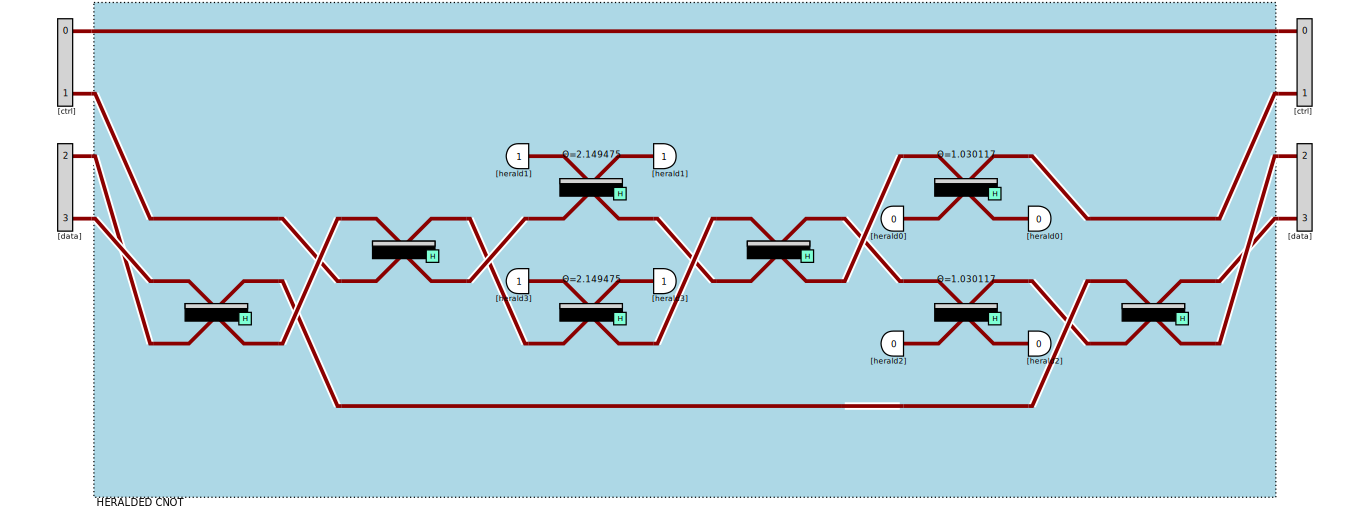

In [2]:
cnot = catalog["klm cnot"].build_processor()
pcvl.pdisplay(cnot, recursive=True)

Instantiating a *ProcessTomography* object with KLM CNOT gate from Perceval's catalog with a perfect source and computing the $\chi$ matrix for the gate operation.

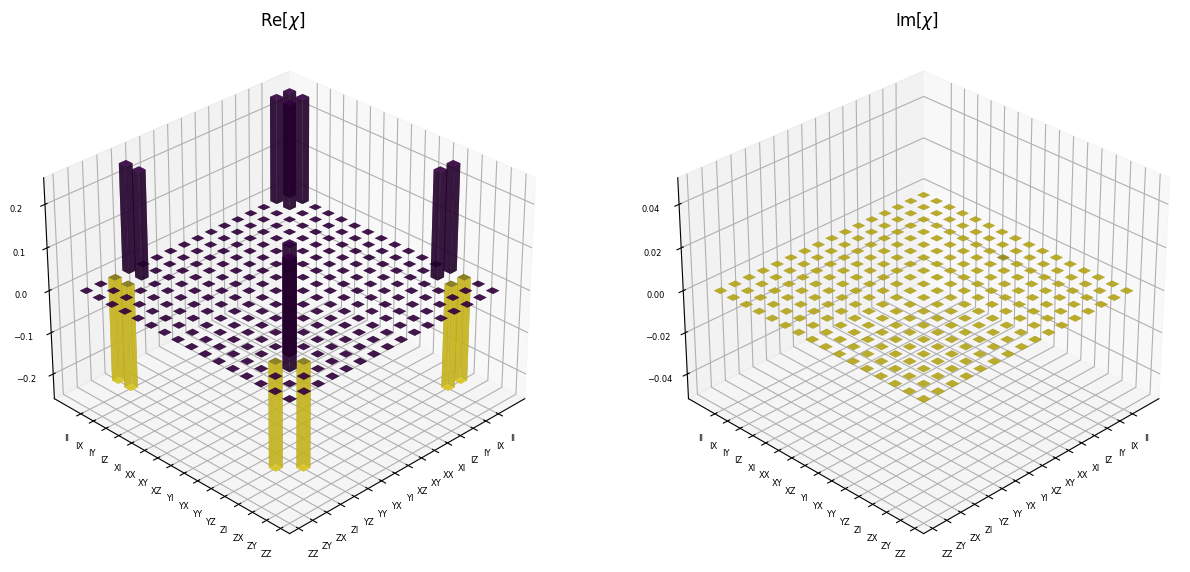

In [3]:
qpt = ProcessTomography(operator_processor=cnot)
chi_op = qpt.chi_matrix()  # computing the chi matrix
pcvl.pdisplay(qpt, render_size=(15,30))  # visualization of the same chi

## Process Fidelity Computations

Once having the χ matrix, it might be useful to know how close the heralded gate is to the real CNOT operation. We can compute the process fidelity $$F_{\chi}= Tr({\chi}_{ideal} {\chi}_{physical})$$

In [4]:
# checking fidelity
op_CX = np.array([[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 0, 1],
             [0, 0, 1, 0]], dtype='complex_')

chi_op_ideal = qpt.chi_target(op_CX)
cnot_fidelity = qpt.process_fidelity(chi_op, chi_op_ideal)
print("Process Fidelity of CNOT gate operation", cnot_fidelity)

Process Fidelity of CNOT gate operation 1.0000000000000075


As expected, the fidelity is close to one. The gate behaves as we want. However, we can see that it is not exactly 1, while we are in the ideal case.

## Average fidelity
Computing the process fidelity can be quite long because we are manipulating matrices that scale exponentially with the number of qubits. If we are only interested in the fidelity of the gate, we can compute its average fidelity : $$\bar{F}= \frac{1}{d+1}+\frac{1}{d^2(d+1)}\sum_j Tr(U E_j^\dag U^\dag \varepsilon(E_j))$$

In [5]:
f_avg = qpt.average_fidelity(op_CX)
print("average fidelity :",f_avg)

average fidelity : 0.9999999999999963


## Physicality of the maps

When we reconstruct a process map, an important question is to know whether it is physical or not. A map is called physical if it is trace-preserving (TP), Hermitian, and completely positive (CP).

A map is TP if its $\chi$ matrix is trace 1. To check the CP part is a bit more difficult: The general algorithm (for finite dimensions is using the Choi-Jamiolkowski-isomorphism.

A map $\epsilon$ is CP iff the Choi matrix
$$S:=(\varepsilon \otimes I_d)(\ket{\Omega}\bra{\Omega})$$
is a positive semidefinite matrix, where ∣Ω⟩=∑i=1d​∣ii⟩ is the maximally entangled state.

In [6]:
print('Results from testing the physicality of the Chi matrix for the CNOT gate operation')
print(is_physical(chi_op, 2))

Results from testing the physicality of the Chi matrix for the CNOT gate operation
{'Trace=1': True, 'Hermitian': True, 'Completely Positive': True}


It must be mentioned that the $\chi$ computed by tomography is normalized by the gate efficiency to be a trace preserving physical map. The user can, however, ask for the un-normalized $\chi$ and the gate efficiency if needed.

In [7]:
chi_raw = qpt.chi_unnormalized
gate_eff = qpt.gate_efficiency
print("Un normalized Chi matrix is not physical: not Trace preserving")
print(is_physical(chi_raw, 2))
print("Gate efficiency of the KLM CNOT implemented is =", gate_eff)

Un normalized Chi matrix is not physical: not Trace preserving
{'Trace=1': False, 'Hermitian': True, 'Completely Positive': True}
Gate efficiency of the KLM CNOT implemented is = (0.05132078828084495-9.48382389397376e-18j)


## Error Process Map

A nice way to highlight the errors in the computation is to look at the error process map. $$\chi_{err}=V \chi V^†$$

$$V_{mn} = \frac{Tr(E_m^† E_n U^†)}{d}$$

The error map is computed in the following cell by incorporating source imperfections to the CNOT gate processor.

In [8]:
# Error map for an operation with an imperfect source with properties g2=0.00732, indistinguishability=0.9438
src = Source(multiphoton_component=0.00732, indistinguishability=0.9438)
cnot_imperfect_src = catalog["klm cnot"].build_processor()
cnot_imperfect_src.source = src

qpt_imperfect_source = ProcessTomography(nqubit=2, operator_processor=cnot_imperfect_src)
chi_op_imperfect_src = qpt_imperfect_source.chi_matrix()  # computing the chi matrix

U=qpt.error_process_matrix(chi_op_imperfect_src, op_CX)

# many values too small in U, filtering them out
U = np.where(abs(U)<1e-6, 0, U)
print(U)

[[ 9.56195332e-01+1.27108717e-16j  3.66383889e-03+3.57689473e-16j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -7.95114517e-06-3.05838587e-06j  5.79631170e-05+2.69291653e-05j
   0.00000000e+00+0.00000000e+00j -1.98569892e-06+3.89916607e-07j
  -7.95114517e-06+3.05838587e-06j  5.79631170e-05-2.69291653e-05j
   0.00000000e+00+0.00000000e+00j  1.98569892e-06+3.89916607e-07j
   3.67912712e-03-3.50619359e-17j  5.53891565e-03+1.44331956e-16j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 3.66383889e-03-2.95479438e-16j  1.78873710e-02-2.48093149e-17j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -1.19984232e-05-4.56895217e-06j -7.95114517e-06-3.05838587e-06j
  -3.89916607e-07-1.98569892e-06j  0.00000000e+00+0.00000000e+00j
  -1.19984232e-05+4.56895217e-06j -7.95114517e-06+3.05838587e-06j
  -3.89916607e-07+1.98569892e-06j  0.00000000e+00+0.00000000e+00j
  -1.00386135e-02-1.71086411e-16j  5.21865206e-03-5.13911599e-17j
   0.0000

The upper left coefficient is the process fidelity while all the other non-zero coefficients represent some kind of errors. For example, non-zero imaginary coefficients on the first row (or first column) represent first-order unitary errors. Non-zero diagonal coefficients represent Pauli errors.